## DEMENT in parallel

In [1]:
#..Load modules
import os
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
from initialization_new import initialize_data
from grid_new import Grid
from output_gradcatch import Output
from utility import export

In [3]:
input_folder  = "input"   # input folder name
#...Set up the working directory
os.chdir(input_folder)

In [4]:
import joblib
from joblib import Parallel, delayed

In [5]:
def dement(outname, random_seed):
    #outname_t[i]  = "20220221" + str(int(i))    # output file name and seed of Pseudo-RNG + "20220211"
    input_folder  = "input"   # input folder name 
    output_folder = "output"  # output folder name
    #outname       = outname_t[i]
    #outname       = "20220131"   # output file name and seed of Pseudo-RNG
    #...Set up the working directory
    #  os.chdir(input_folder)
    #...seed the pseudorandom number generator
    np.random.seed(random_seed)

    #...a few system constants
    runtime    = pd.read_csv('runtime_orig.txt',header=None,index_col=0,sep='\t')
    pulse      = int(runtime.loc['pulse',1])         # number of pulses
    cycle      = int(runtime.loc['end_time',1])      # number of time steps in each pulse
    interval   = int(runtime.loc['interval',1])      # interval of time step to record outputs
    mic_reinit = True    # indicate reinitialization of microbial community

    #...Initialize data by calling the Function: Initialize_Data()
    data_initialization = initialize_data(runtime)

    #...Prepare for output by creating an instance of the Output class
    Output_init = Output(runtime,data_initialization)

    #...Create an instance of the Grid class
    Ecosystem = Grid(runtime,data_initialization)

    #...Run the model
    for p in range(pulse):
        for i in range(p*cycle, (p+1)*cycle):
    
            # substrates degradation
            Ecosystem.degradation(p,i)

            # monomers uptake
            Ecosystem.uptake(p,i)

            # microbial metabolism
            Ecosystem.metabolism(i)

            # microbial death
            Ecosystem.mortality(i)

            # microbial reproduction and dispersal
            Ecosystem.reproduction(i)
    
            # output data using the "output" method in the Output class
            if i == 0:
                Output_init.output(Ecosystem,i)  # day 1
            elif i%interval==interval-1:
                Output_init.output(Ecosystem,i)  # interval
        
            # if only 1 pusle, skip all following lines within this loop
            #if pulse == 1:
            #    continue

            # output microbial mass of every iteration using the "microbes_df" method in the Output class
            Output_init.microbes_abundance(Ecosystem,i)

            # re-initialize microbial community in each new pulse
            if i == (p+1)*cycle-1:
                Ecosystem.repopulation(Output_init,i,mic_reinit)

    return Output_init

results = Parallel(n_jobs=2)(delayed(dement)("20240331" + str(int(i)),i) for i in range(2))

In [ ]:
%debug

In [6]:
import pickle
output = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/newB.pkl', 'wb')
pickle.dump(results, output)
output.close()

## Open the pickle output

In [7]:
#import 
import pickle
pkl_file = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/newB.pkl', 'rb')
test     = pickle.load(pkl_file)
pkl_file.close()

## Test Plots

In [8]:
tt        = np.linspace(0,1,2) # Number of repetitions = 4
time      = np.linspace(0,365*3,365*3+1)

### Respiration

In [9]:
respi_base     = []

for i in tt:
        respi_base.append(test[int(i)].RespSeries)

Respi_mean = (np.array(respi_base).mean(axis=0))
respiration_5  = np.percentile(respi_base,5,axis=0)
respiration_95 = np.percentile(respi_base,95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_22368\187784392.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


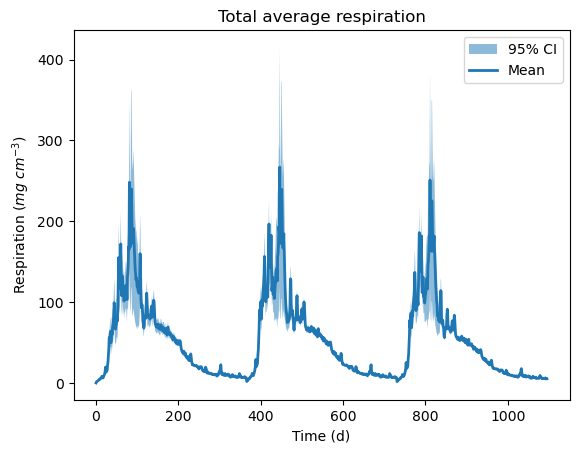

In [10]:
fig, ax = plt.subplots()

ax.fill_between(time,respiration_5,respiration_95, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Respi_mean, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Respiration ($mg$ $cm^{-3}$)') 
plt.title('Total average respiration') 
ax.legend()
fig.show()

In [11]:
Subst_tot = []

for i in tt:
    Subst_tot.append(test[int(i)].SubstratesSeries)

Sub_sum     = np.mean((np.array(Subst_tot).sum(axis=1)),axis=0)
Sub_05      = np.percentile((np.array(Subst_tot).sum(axis=1)),5,axis=0)
Sub_95      = np.percentile((np.array(Subst_tot).sum(axis=1)),95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_22368\3386710776.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


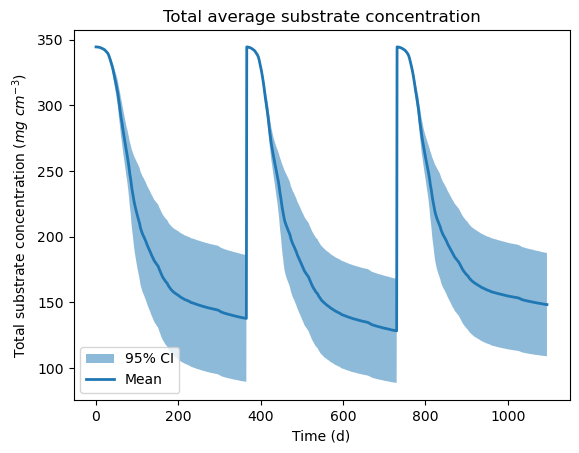

In [12]:
fig, ax = plt.subplots()

ax.fill_between(time,Sub_05/100,Sub_95/100, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Sub_sum/100, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Total substrate concentration ($mg$ $cm^{-3}$)') 
plt.title('Total average substrate concentration') 
ax.legend(loc="lower left")
fig.show()

In [13]:
DeadMic         = []
DeadEnz         = []
Cellulose       = []
Hemicellulose   = []
Starch          = []
Chitin          = []
Lignin          = []
Protein1        = []
Protein2        = []
Protein3        = []
OrgP1           = []
OrgP2           = []

for i in tt:
  DeadMic.append(Subst_tot[int(i)].T["DeadMic"])
  DeadEnz.append(Subst_tot[int(i)].T["DeadEnz"])
  Cellulose.append(Subst_tot[int(i)].T["Cellulose"])
  Hemicellulose.append(Subst_tot[int(i)].T["Hemicellulose"])
  Starch.append(Subst_tot[int(i)].T["Starch"])
  Chitin.append(Subst_tot[int(i)].T["Chitin"])
  Lignin.append(Subst_tot[int(i)].T["Lignin"])
  Protein1.append(Subst_tot[int(i)].T["Protein1"])
  Protein2.append(Subst_tot[int(i)].T["Protein2"])
  Protein3.append(Subst_tot[int(i)].T["Protein3"])
  OrgP1.append(Subst_tot[int(i)].T["OrgP1"])
  OrgP2.append(Subst_tot[int(i)].T["OrgP2"])
DeadMic_mean = (np.array(DeadMic).mean(axis=0))
DeadEnz_mean = (np.array(DeadEnz).mean(axis=0))
Cellulose_mean = (np.array(Cellulose).mean(axis=0))
Hemicellulose_mean = (np.array(Hemicellulose).mean(axis=0))
Starch_mean = (np.array(Starch).mean(axis=0))
Chitin_mean = (np.array(Chitin).mean(axis=0))
Lignin_mean = (np.array(Lignin).mean(axis=0))
Protein1_mean = (np.array(Protein1).mean(axis=0))
Protein2_mean = (np.array(Protein2).mean(axis=0))
Protein3_mean = (np.array(Protein3).mean(axis=0))
OrgP1_mean = (np.array(OrgP1).mean(axis=0))
OrgP2_mean = (np.array(OrgP2).mean(axis=0))

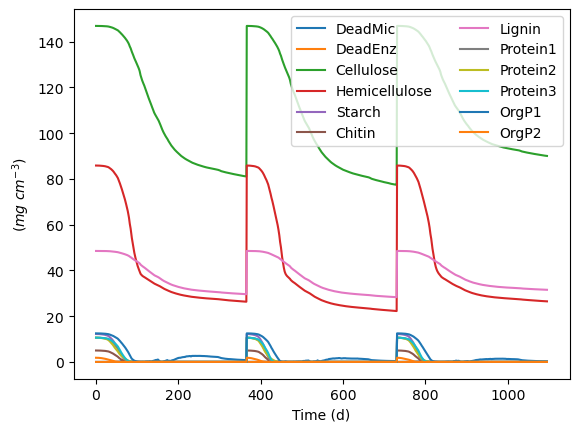

In [14]:
plt.plot(time, DeadMic_mean/100, label = "DeadMic") 
plt.plot(time, DeadEnz_mean/100, label = "DeadEnz") 
plt.plot(time, Cellulose_mean/100, label = "Cellulose") 
plt.plot(time, Hemicellulose_mean/100, label = "Hemicellulose") 
plt.plot(time, Starch_mean/100, label = "Starch") 
plt.plot(time, Chitin_mean/100, label = "Chitin") 
plt.plot(time, Lignin_mean/100, label = "Lignin") 
plt.plot(time, Protein1_mean/100, label = "Protein1")
plt.plot(time, Protein2_mean/100, label = "Protein2")
plt.plot(time, Protein3_mean/100, label = "Protein3")
plt.plot(time, OrgP1_mean/100, label = "OrgP1")
plt.plot(time, OrgP2_mean/100, label = "OrgP2")
plt.legend() 
plt.xlabel('Time (d)') 
plt.ylabel('($mg$ $cm^{-3}$)') 
plt.legend(ncol=2)
plt.show()